# 0 Installation

## 0.1 install condacolab [restarts after installation]

In [1]:
# Install condacolab
!pip install -q condacolab

import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:13
🔁 Restarting kernel...


## 0.2 install cudatoolkit, openmm, pdbfixers

In [1]:
# Step 0: Reinstall OpenMM with CUDA toolkit 11.8
!mamba install -y -c conda-forge cudatoolkit=11.8 openmm
# Use mamba (much faster than conda) to install OpenMM + helpers
!mamba install -y -c conda-forge openmmtools pdbfixer


Looking for: ['cudatoolkit=11.8', 'openmm']

[+] 0.0s
conda-forge/linux-64  ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   3%
conda-forge/noarch     3%[+] 0.3s
conda-forge/linux-64  14%
conda-forge/noarch    25%[+] 0.4s
conda-forge/linux-64  24%
conda-forge/noarch    42%[+] 0.5s
conda-forge/linux-64  28%
conda-forge/noarch    50%[+] 0.6s
conda-forge/linux-64  33%
conda-forge/noarch    63%[+] 0.7s
conda-forge/linux-64  40%
conda-forge/noarch    77%[+] 0.8s
conda-forge/linux-64  45%
conda-forge/noarch    83%[+] 0.9s
conda-forge/linux-64  47%
conda-forge/noarch    92%conda-forge/noarch                                
[+] 1.0s
conda-forge/linux-64  53%[+] 1.1s
conda-forge/linux-64  60%[+] 1.2s
conda-forge/linux-64  68%[+] 1.3s
conda-forge/linux-64  79%[+] 1.4s
conda-forge/linux-64  85%[+] 1.5s
conda-forge/linux-64  93%conda-forge/linux-64                              

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.

## 0.3 checks available platforms for cuda

In [2]:
from openmm import Platform

print("Available OpenMM platforms:")
for idx in range(Platform.getNumPlatforms()):
    plat = Platform.getPlatform(idx)
    props = plat.getPropertyNames()
    print(f"  {idx}: {plat.getName()} → {props}")


Available OpenMM platforms:
  0: Reference → ()
  1: CPU → ('Threads', 'DeterministicForces')
  2: CUDA → ('DeviceIndex', 'DeviceName', 'UseBlockingSync', 'Precision', 'UseCpuPme', 'CudaCompiler', 'TempDirectory', 'CudaHostCompiler', 'DisablePmeStream', 'DeterministicForces')
  3: OpenCL → ('DeviceIndex', 'DeviceName', 'OpenCLPlatformIndex', 'OpenCLPlatformName', 'Precision', 'UseCpuPme', 'DisablePmeStream')


# 01 openmm 1ns

## 1.1 EM, NPT, NVT

In [ ]:
# Full Lysozyme (1AKI) NPT MD with extended NVT equilibration, logging & final snapshot
# ───────────────────────────────────────────────────────────────────────────────

# 1) Download lysozyme PDB
!wget -q https://files.rcsb.org/download/1AKI.pdb

# 2) Imports
from pdbfixer import PDBFixer
from openmm.app import (
    PDBFile, Modeller, ForceField,
    Simulation, PDBReporter, StateDataReporter
)
from openmm import (
    unit, MonteCarloBarostat, LangevinIntegrator,
    Platform
)
import openmm as mm
import sys

# 3) Clean & prepare PDB
fixer = PDBFixer(filename='1AKI.pdb')
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.removeHeterogens(keepWater=False)
fixer.addMissingHydrogens(pH=7.0)
PDBFile.writeFile(fixer.topology, fixer.positions,
                  open('fixed_1AKI.pdb','w'))

# 4) Load structure & force field
pdb        = PDBFile('fixed_1AKI.pdb')
forcefield = ForceField('amber14-all.xml', 'tip3p.xml')

# 5) Solvate & build topology
modeller = Modeller(pdb.topology, pdb.positions)
modeller.deleteWater()
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model='tip3p',
    padding=1.0*unit.nanometer, neutralize=False)

# 6) Build system + barostat
system = forcefield.createSystem(modeller.topology,
    nonbondedMethod=mm.app.PME,
    nonbondedCutoff=1.0*unit.nanometer,
    constraints=mm.app.HBonds
)
system.addForce(MonteCarloBarostat(1*unit.bar, 300*unit.kelvin, 25))

# 7) Create 2 fs Langevin integrator for equilibration
integrator = LangevinIntegrator(
    300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds
)

# 8) Select CUDA GPU platform
platform = Platform.getPlatformByName('CUDA')
platform.setPropertyDefaultValue('DeviceIndex','0')
platform.setPropertyDefaultValue('Precision','mixed')

# 9) Initialize Simulation
simulation = Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPeriodicBoxVectors(*modeller.topology.getPeriodicBoxVectors())
simulation.context.setPositions(modeller.positions)
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

# 10) Minimize
print("Minimizing energy…")
simulation.minimizeEnergy(maxIterations=1000)
print("Minimization complete.")

# 11) Attach reporters
simulation.reporters.append(PDBReporter('output.pdb', 500))  # every 1 ps (500 steps)
simulation.reporters.append(StateDataReporter(
    'md_log.txt', 1, step=True,
    potentialEnergy=True, temperature=True, volume=True
))
print("Reporters attached.")

# 12) Extended NVT equilibration: 100 ps → 50 000 steps @2 fs
nvt_steps = int(100*unit.picoseconds / integrator.getStepSize())
print(f"Running extended NVT equilibration ({nvt_steps} steps)…")
simulation.step(nvt_steps)
print("Extended NVT equilibration complete.")

# 13) NPT production: 10 ps → 5000 steps @2 fs
print("Running NPT production (10 ps)…")
simulation.step(int(10*unit.picoseconds / integrator.getStepSize()))
print("NPT production complete.")

# ───────────────────────────────────────────────────────────────────────────────
# 14) SAVE FINAL SNAPSHOT & BOX VECTORS
# ───────────────────────────────────────────────────────────────────────────────
state = simulation.context.getState(
    getPositions=True,
    enforcePeriodicBox=True
)

# 14a) Write out final coordinates
with open('final_snapshot.pdb', 'w') as f:
    PDBFile.writeFile(simulation.topology,
                      state.getPositions(),
                      f)

# 14b) Record the periodic box vectors
box = state.getPeriodicBoxVectors()
with open('final_box.txt', 'w') as f:
    f.write(f"{box}\n")

print("Final snapshot saved to final_snapshot.pdb")
print("Box vectors saved to final_box.txt")

# 15) Show first lines of log
print("--- md_log.txt preview ---")
!head -n 10 md_log.txt


Minimizing energy…
Minimization complete.
Reporters attached.
Running extended NVT equilibration (50000 steps)…
Extended NVT equilibration complete.
Running NPT production (10 ps)…
NPT production complete.
Final snapshot saved to final_snapshot.pdb
Box vectors saved to final_box.txt
--- md_log.txt preview ---
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1,-371404.65815202147,305.01099197303813,248.7176450931865
2,-365673.71869955445,283.1564709540638,248.7176450931865
3,-359406.4125274385,251.6392225733703,248.7176450931865
4,-354228.333167898,222.89156563097137,248.7176450931865
5,-350120.83733440307,200.4785012542201,248.7176450931865
6,-346764.9370318083,182.35905782770448,248.7176450931865
7,-344416.8609647779,168.2999909229552,248.7176450931865
8,-343727.4218301757,161.09278522172806,248.7176450931865
9,-344537.82262799074,162.3849376069572,248.7176450931865


## 1.2 MD 1ns

In [ ]:
from openmm.app import DCDReporter, CheckpointReporter, StateDataReporter

# ─── Attach production reporters ───────────────────────────────────────────────
simulation.reporters.append(DCDReporter('production_1ns.dcd', 1000))
simulation.reporters.append(StateDataReporter(
    'production_1ns_log.txt',
    5000,
    step=True,
    potentialEnergy=True,
    temperature=True,
    volume=True
))
simulation.reporters.append(CheckpointReporter(
    'production_1ns.chk',
    5000
))
print("Production reporters for 1 ns attached.")

# ─── Compute number of steps for 1 ns ───────────────────────────────────────────
n_prod_steps = int(1 * unit.nanoseconds / integrator.getStepSize())
print(f"Running {n_prod_steps} steps (~1 ns)")

# ─── Run 1 ns production ───────────────────────────────────────────────────────
simulation.step(n_prod_steps)
print("1 ns production MD complete.")
print(" → Trajectory: production_1ns.dcd")
print(" → Log:        production_1ns_log.txt")
print(" → Checkpoints: production_1ns.chk")


Production reporters for 1 ns attached.
Running 500000 steps (~1 ns)
1 ns production MD complete.
 → Trajectory: production_1ns.dcd
 → Log:        production_1ns_log.txt
 → Checkpoints: production_1ns.chk


## extra: MD 10ns

In [ ]:
from openmm.app import DCDReporter, CheckpointReporter, StateDataReporter

# ─── Attach production reporters ───────────────────────────────────────────────
# (you can leave these as-is, or decrease frequency if you want fewer, larger files)
simulation.reporters.append(DCDReporter('production_10ns.dcd', 5000))
simulation.reporters.append(StateDataReporter(
    'production_10ns_log.txt',
    25000,                # log every 25 000 steps (~50 ps with 2 fs timestep)
    step=True,
    potentialEnergy=True,
    temperature=True,
    volume=True
))
simulation.reporters.append(CheckpointReporter(
    'production_10ns.chk',
    25000                # checkpoint every 25 000 steps
))
print("Production reporters for 10 ns attached.")

# ─── Compute number of steps for 10 ns ─────────────────────────────────────────
n_prod_steps = int(10 * unit.nanoseconds / integrator.getStepSize())
print(f"Running {n_prod_steps} steps (~10 ns)")

# ─── Run 10 ns production ─────────────────────────────────────────────────────
simulation.step(n_prod_steps)
print("10 ns production MD complete.")
print(" → Trajectory: production_10ns.dcd")
print(" → Log:        production_10ns_log.txt")
print(" → Checkpoints: production_10ns.chk")


## extra: MD 10ns w/ ETA

In [ ]:
import time
from openmm import unit

def run_with_progress(simulation, total_steps, chunk_steps=50000):
    """
    Runs the simulation in chunks, printing elapsed and remaining time.

    Parameters
    ----------
    simulation : openmm.app.Simulation
        Your OpenMM simulation object.
    total_steps : int
        Total number of integration steps to run.
    chunk_steps : int
        Number of steps to run between each progress print.
    """
    n_full = total_steps // chunk_steps
    rem    = total_steps % chunk_steps
    step_done = 0
    t0 = time.time()

    for i in range(n_full):
        simulation.step(chunk_steps)
        step_done += chunk_steps

        elapsed = time.time() - t0
        rate    = elapsed / step_done             # seconds per step
        remain  = (total_steps - step_done) * rate

        print(f"Completed {step_done:,}/{total_steps:,} steps "
              f"(elapsed: {elapsed:.1f}s, ETA: {remain:.1f}s)")

    if rem:
        simulation.step(rem)
        step_done += rem
        elapsed = time.time() - t0
        print(f"Completed {step_done:,}/{total_steps:,} steps "
              f"(elapsed: {elapsed:.1f}s, ETA: 0.0s)")

    print("→ Production complete.")

# ─── Setup your reporters as before ────────────────────────────────────────────
from openmm.app import DCDReporter, CheckpointReporter, StateDataReporter

simulation.reporters.append(DCDReporter('production_10ns.dcd', 5000))
simulation.reporters.append(StateDataReporter(
    'production_10ns_log.txt', 25000,
    step=True, potentialEnergy=True,
    temperature=True, volume=True
))
simulation.reporters.append(CheckpointReporter(
    'production_10ns.chk', 25000
))

# ─── Compute steps for 10 ns (2 fs timestep) ─────────────────────────────────
n_prod_steps = int(10 * unit.nanoseconds / integrator.getStepSize())
print(f"Starting 10 ns production: {n_prod_steps:,} steps")

# ─── Run with progress reporting ───────────────────────────────────────────────
run_with_progress(simulation, n_prod_steps, chunk_steps=50000)


# 02 Analysis

In [ ]:
!pip install "MDAnalysis[analysis]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 138.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.2 MB/s eta 0:00:00


## 2.1 RMSD

/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rms.py:824: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


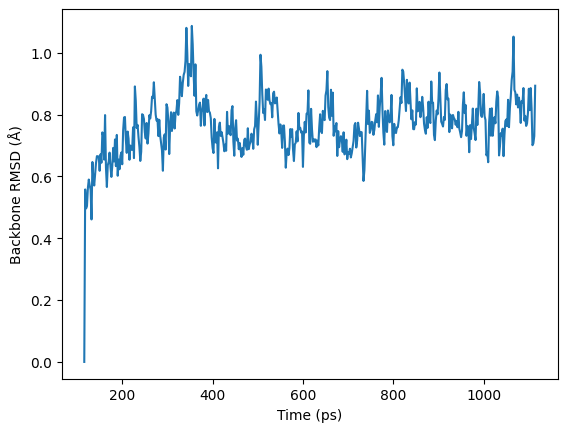

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt

# Load the full‐system PDB + DCD
u = mda.Universe('final_snapshot.pdb', 'production_1ns.dcd')

# Select only the protein backbone for the RMSD
prot = u.select_atoms('protein and backbone')

# Build a reference from the first frame
ref = mda.Merge(prot).universe  # just copy the same Universe, but we'll grab its 0th frame
ref.trajectory[0]               # go to frame 0

# Compute RMSD of mobile (prot) vs. ref (prot)
R = rms.RMSD(prot, ref.select_atoms('protein and backbone')).run()

times = R.rmsd[:,1]  # in ps, if your DCD has time
rmsd  = R.rmsd[:,2]  # in Å

plt.figure()
plt.plot(times, rmsd)
plt.xlabel('Time (ps)')
plt.ylabel('Backbone RMSD (Å)')
plt.show()


## 2.2 RMSF

/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rms.py:1000: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


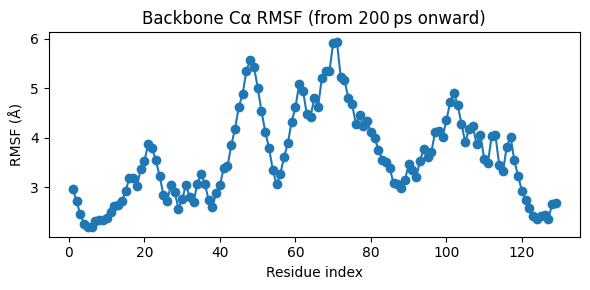

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSF
import matplotlib.pyplot as plt
import numpy as np

# 1) Load full system
u = mda.Universe('final_snapshot.pdb', 'production_1ns.dcd')

# 2) Select just the protein Cα atoms
ca = u.select_atoms('protein and name CA')

# 3) Figure out which frames correspond to 200 ps
#    MDAnalysis stores time in ts.time (in ps) if it's in the DCD header
times = [ts.time for ts in u.trajectory]
eq_cut = 200.0
start_frame = next(i for i,t in enumerate(times) if t >= eq_cut)

# 4) Run RMSF from start_frame → end
R = RMSF(ca, start=start_frame, stop=None).run()

# 5) Plot RMSF vs. residue number
resids = ca.resids
plt.figure(figsize=(6,3))
plt.plot(resids, R.rmsf, marker='o', linestyle='-')
plt.xlabel('Residue index')
plt.ylabel('RMSF (Å)')
plt.title(f'Backbone Cα RMSF (from {eq_cut:.0f} ps onward)')
plt.tight_layout()
plt.show()


## 2.3 RG

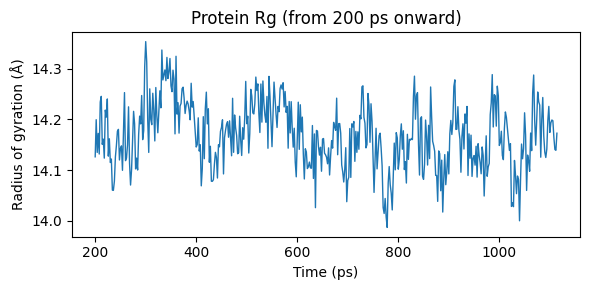

Equilibrated Rg: 14.168 ± 0.064 Å


In [ ]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

# 1) Load full system
u = mda.Universe('final_snapshot.pdb', 'production_1ns.dcd')

# 2) Select just the protein atoms
prot = u.select_atoms('protein')

# 3) Loop over trajectory and record time & Rg
times = []
rgs   = []
for ts in u.trajectory:
    times.append(ts.time)                      # time in ps
    rgs.append(prot.radius_of_gyration())      # Rg in Å

times = np.array(times)
rgs   = np.array(rgs)

# 4) Discard equilibration (first 200 ps)
mask = times >= 200.0
times_eq = times[mask]
rgs_eq   = rgs[mask]

# 5) Plot
plt.figure(figsize=(6,3))
plt.plot(times_eq, rgs_eq, linewidth=1)
plt.xlabel('Time (ps)')
plt.ylabel('Radius of gyration (Å)')
plt.title('Protein Rg (from 200 ps onward)')
plt.tight_layout()
plt.show()

# 6) Report mean ± SD in equilibrated window
mean_rg = np.mean(rgs_eq)
std_rg  = np.std(rgs_eq)
print(f"Equilibrated Rg: {mean_rg:.3f} ± {std_rg:.3f} Å")
